# **Laboratorio 12:** Detección de Objetos
**Programa:** [Bootcamp en Visión Artificial para los ODS](https://github.com/EdwinTSalcedo/Bootcamp-Computer-Vision-for-the-SDGs) - **Autor:** [Edwin Salcedo](https://github.com/EdwinTSalcedo)

Hasta ahora, nos centramos en clasificar imágenes con un único objeto, usando un conjunto cerrado de categorías. Sin embargo, hay proyectos que requieren detectar imágenes con uno o varios elementos de diferente clase. Localizar y etiquetar esos elementos puede ser de mucha ayuda como en el siguiente ejemplo: 

<center>
<img src='https://thumbs.gfycat.com/DisastrousGaseousAnole-max-1mb.gif' width='30%'>
</center> 

La tarea de detección de objetos tiene la finalidad de encontrar un conjunto de elementos en una imagen y definir una categoría para cada uno. Esta tarea, entre otras mas avanzas como la segmentación basada en redes neuronales, requiere de arquitecturas complejas que pueden llegar a ser todo un proyecto de investigación. Para facilitar su aplicación, se sugiere utilizar arquitecturas que estén disponibles desde los repositorios oficiales de TensorFlow. 

El [TensorFlow Model Garden](https://github.com/tensorflow/models) es uno de los repositorios mas grande de modelos oficiales, modelos en investigación, y modelos desarrollados por la comunidad. Estos modelos pueden ser descargados y modificados para realizar una tarea en especifico, similar lo que vimos en la lección de transferencia de aprendizaje. Por otro lado, el [TensorFlow Hub](https://www.tensorflow.org/hub) es otro repositorio para reutilizar modelos pre entrenados. En esa oportunidad, nos centraremos en este último, para aprovechar uno de sus modelos de detección de objetos. 

Este laboratorio esta basado en el tutorial de [TensorFlow para detección de objetos](https://www.tensorflow.org/hub/tutorials/object_detection) y contiene varias mejoras con respecto al tutorial original. 

## 1. Configuración del entorno 
Importar todas las bibliotecas necesarias en la etapa de preprocesamiento y entrenamiento.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, requests
import cv2

# Libería para medir el tiempo de ejecución
import time

# TensorFlow Hub es un repositorio de modelos de aprendizaje automático entrenados, 
# listos para optimizarlos e implementarlos donde quieras. Puedes reutilizar modelos 
# entrenados, como BERT y Faster R-CNN, con solo unas pocas líneas de código.
import tensorflow_hub as hub

# Pil es una librería completar para procesar imágenes
# En este laboratorio, lo usaremos para dibujar bounding boxes dentro de la imagen
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

# Esta librería permite crear archivos y carpetas temporales
import tempfile

# Mostrar la versión de TensorFlow
print(tf.__version__)

# Verificar los dispositivos GPU disponibles 
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.2
The following GPU devices are available: /device:GPU:0


## 2. Declarar funciones de ayuda

In [ ]:
# Código de visualización adaptado de la [API de Detección de Objetos de TensorFlow](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) 

def display_image(image):
  '''Esta función muestra una imagen'''
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  '''Esta función descarga una imagen y ajusta su tamaño'''
  
  # Detectar extensión de imagen
  splits = url.split(".")
  extension = splits[len(splits)-1]

  # Asignar nombre de archivo temporal
  filename = "image."+extension

  # Descargar imagen
  img_data = requests.get(url, verify=False).content
  with open(filename, 'wb') as handler:
      handler.write(img_data)

  # Abrir imagen con opencv 
  image = cv2.imread(filename)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Cambiar el tamaño de la imagen 
  resized = cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_AREA)

  # Guardar imagen
  cv2.imwrite(filename, cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

  if display:
    display_image(resized)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  '''Esta función dibuja un bounding box a una imagen'''
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # Si la longitud total de las cadenas (strings con las etiquetas) excede la parte superior de la imagen
  # , agrega las cadenas debajo del cuadro delimitador en lugar de ubicarlas arriba.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Cada display_str tiene un margen superior e inferior de 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  # Invertir la lista e imprimir de abajo hacia arriba.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Esta función superpone bounding boxes predecidos en una imagen con los 
   scores de detección de objetos y nombres de etiquetas."""
  colors = list(ImageColor.colormap.values())

  # Cargar fuente de texto
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  # Dibujar uno o mas bounding boxes
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## 3. Descargar una imagen

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


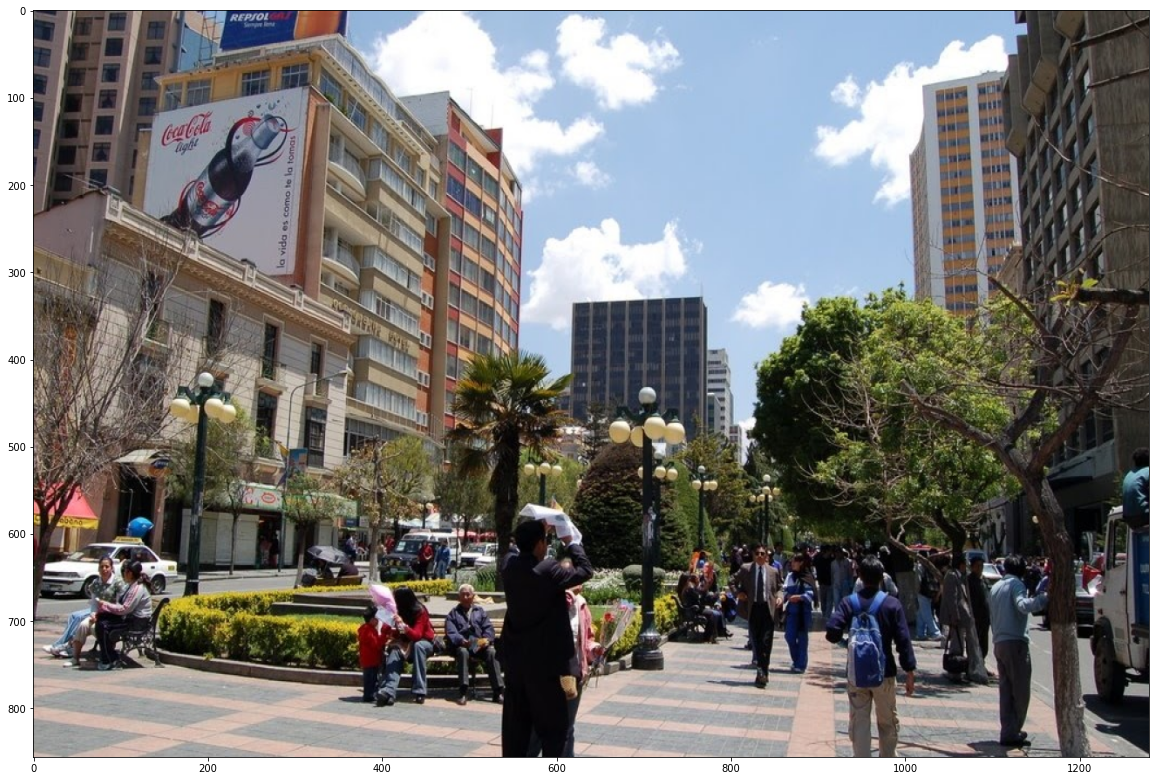

In [ ]:
image_url = "https://4.bp.blogspot.com/_pzd77zHDAPA/SThG3vebwFI/AAAAAAAAAJM/72wAUIoTnSg/w1200-h630-p-k-no-nu/La+Paz+-+el+Prado.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

## 4. Implementar un modelo de detección de objetos

Como se menciono anteriormente, TensorFlow Hub contiene muchos modelos para tareas de clasificación de imágenes, detección de objetos, e incluso, segmentación de instancias. Para la tarea actual, se sugiere revisar el [catálogo completo](https://tfhub.dev/s?module-type=image-object-detection) de modelos para detección de objetos. Una vez encuentres un modelo de tu interes, deberas copiar su Módule Handle. Este se encuentra disponible como una URL en la página de detalle de cada modelo. Por ejemplo: 

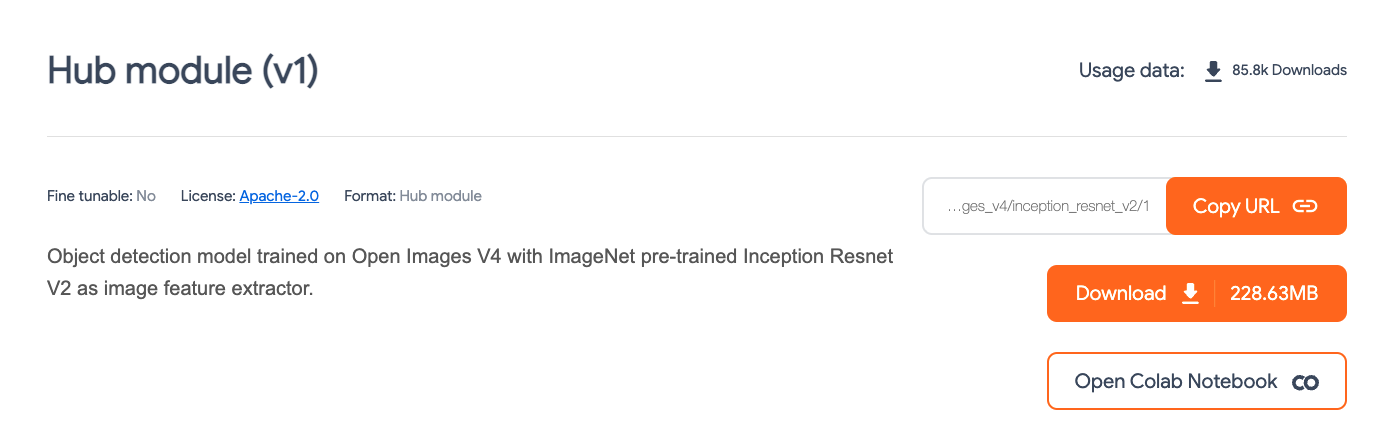








Una vez copiado el URL, deberas incluirlo como parametro para la variable `module_handle` de la celda siguiente. Como ejemplo, puedes probar con los siguientes modelos:
* **FasterRCNN+InceptionResNet V2**: alta precisión.
* **ssd+mobilenet V2**: modelo liviano y rápido.

In [ ]:
# Seleccionar modelo
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

# Cargar modelo
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
  '''Esta función carga una imagen y la convierte a un tensor de TF'''
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  ''' Esta función ejecuta un modelo con una imagen previamente convertida a un tensor '''
  img = load_img(path)

  # Convertir los tensores a float32
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  # Detectar objetos y medir el tiempo de detección
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Número de objetos encontrados: %d ." % len(result["detection_scores"]))
  print("Tiempo de inferencia: ", end_time-start_time)

  # Dibujar bounding boxes en imagen
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  # Mostrar imagen final
  display_image(image_with_boxes)

Número de objetos encontrados: 100 .
Tiempo de inferencia:  1.1158504486083984


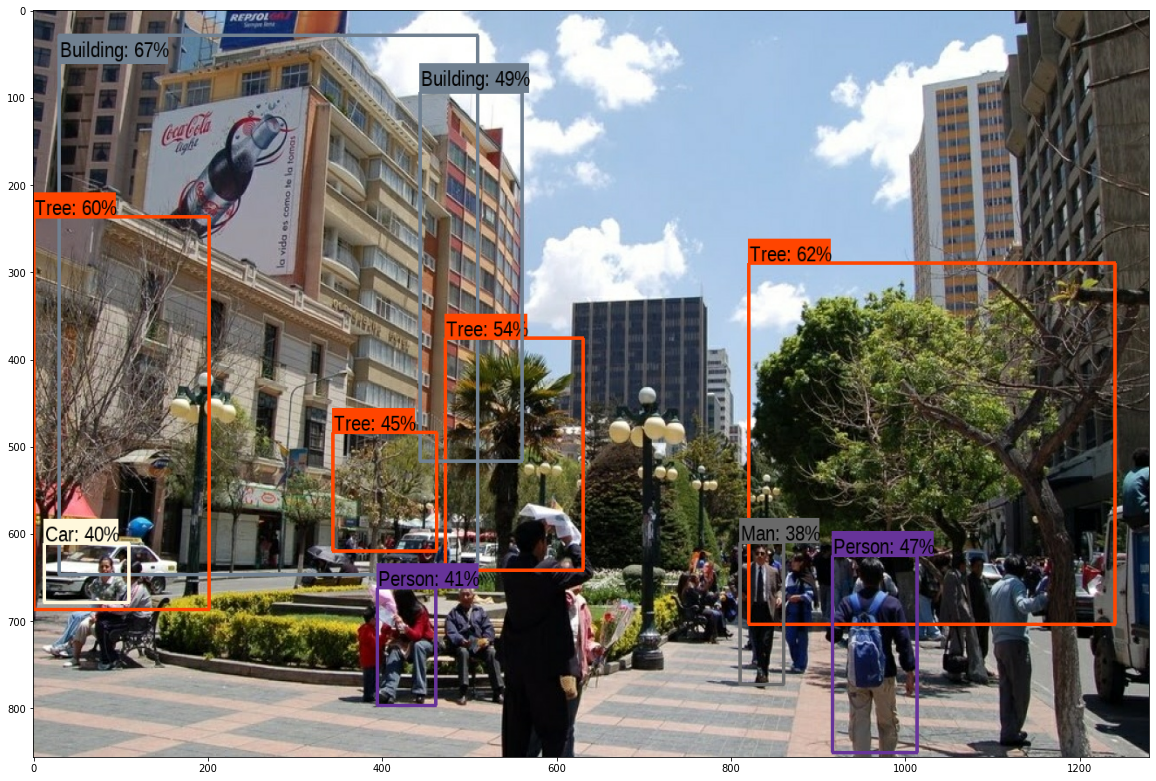

In [ ]:
run_detector(detector, downloaded_image_path)

## **Ejercicio 1:** Transferencia de Aprendizaje

Para este ejercicio deberas aplicar el tutorial [Transfer Learning con TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) para una tarea de clasificación de imágenes o detección de objetos, usando un dataset relacionado a tu proyecto. Aunque puedes usar el dataset que utilizaste en los laboratorios previos, la finalidad de este ejercicio es reutilizar un modelo desde TensorFlow Hub y aplicar Transfer Learning. Por otra parte, mostrar la visualización de los resultados con el **TensorFlow Board** sera obligatorio para este ejercicio. Las indicaciones para realizar esta última parte estan detalladas en el tutorial.